In [6]:
from six.moves import cPickle
import os
import matplotlib.pyplot as plt
import numpy as np
import importlib
import utils as ut
import functions as fu 
from tqdm import tqdm

In [7]:
K, d, n = 10, 3072, 10000
np.random.seed(42)
mu, sigma = 0, 0.01 
batch_start, batch_end= 0, 20

# Explore cifar-10 dataset 

(10000, 32, 32, 3)
D:\Logiciel\anaconda\envs\tf-keras-gpu\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


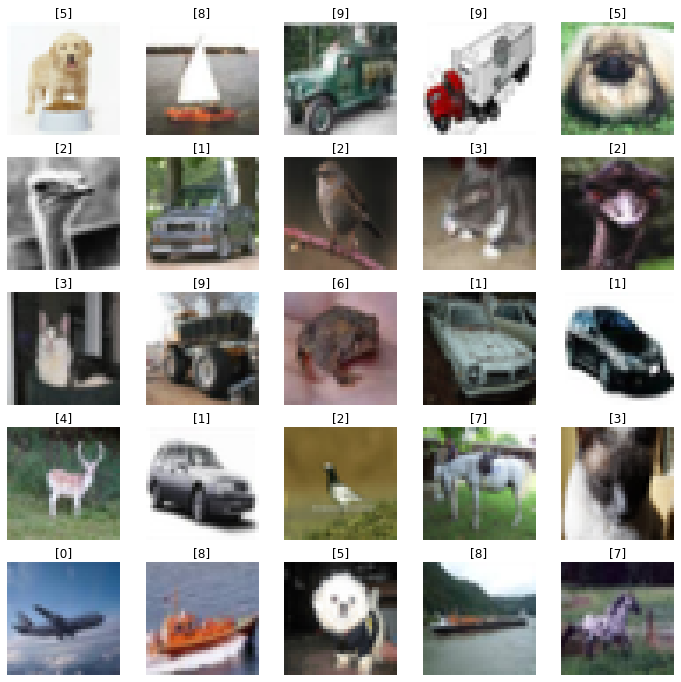

In [5]:
importlib.reload(ut)
X, y, _ = ut.loadData('data_batch_1', reshape=True, clipping=False)
ut.plotCifar(X, y)

# Exercise 1: Trianing a multi-linear classifier

## Data Preprocessing and Loading 

In [8]:
importlib.reload(ut)
X_train, y_train, Y_train = ut.loadData('data_batch_1', clipping=True)
X_val, y_val, Y_val = ut.loadData('data_batch_2', clipping=True)
X_test, y_test, Y_test = ut.loadData('data_batch_3', clipping=True)

## normalize with mean and std of train set 
mean_X = np.mean(X_train, axis=1)
std_X = np.std(X_train, axis=1)

X_train -= np.outer(mean_X, np.ones(X_train.shape[1]))
X_train /= np.outer(std_X, np.ones(X_train.shape[1]))

X_val -= np.outer(mean_X, np.ones(X_val.shape[1]))
X_val /= np.outer(std_X, np.ones(X_val.shape[1]))

X_test -= np.outer(mean_X, np.ones(X_test.shape[1]))
X_test /= np.outer(std_X, np.ones(X_test.shape[1]))

In [6]:
X_train.shape

(3072, 10000)

In [7]:
Y_train.shape

(10, 10000)

In [8]:
mean_X.shape

(3072,)

## Steps check

In [11]:
importlib.reload(ut)
P = ut.EvaluateClassifier(X_train[:, :100], W, b)
print(P.shape)
print(np.argmax(P, axis=0))

(10, 100)
[1 7 9 3 4 8 2 1 6 8 1 6 6 1 7 9 8 8 6 0 5 8 8 4 4 7 8 8 9 6 9 8 1 1 7 4 6
 7 1 1 3 5 5 3 9 1 2 7 6 6 0 8 4 6 7 5 4 7 1 8 9 2 9 8 2 6 1 6 8 6 4 0 0 8
 6 9 6 9 3 5 0 8 1 3 7 8 5 1 8 2 6 8 6 8 6 4 9 8 8 8]


In [13]:
importlib.reload(ut)
cost = ut.ComputeCost(X_train[:,:100], Y_train[:, :100], W , b, 1e-2)
cost

2.3803563016775207

In [14]:
acc = ut.ComputeAccuracy(X_train[:, :100], y_train[:100], W, b)
acc

0.08

## Analytical vs Numerical Gradients

In [9]:
importlib.reload(fu)
batch_size = [1, 32, 64, 100]
lambdas = [0, 0.1, 1]
np.random.seed(42)
for bs in tqdm(batch_size):
    for l in lambdas:
        W = np.random.normal(mu, sigma, (K,d))
        b = np.random.normal(mu, sigma, (K,1))
        P = ut.EvaluateClassifier(X_train[:, :bs], W, b)
        ga_w, ga_b = ut.ComputeGradients(X_train[:, :bs], Y_train[:, :bs], P, W, l)
        ga_b = ga_b.reshape(-1,1)
        gn_w, gn_b = fu.ComputeGradsNumSlow(X_train[:, :bs], Y_train[:, :bs], W, b, l, 1e-6)
        gn_b = gn_b.reshape(-1,1)
        diff_w = np.mean(abs(gn_w - ga_w))
        diff_b = np.mean(abs(gn_b - ga_b))
        rerr_w = np.mean(ut.compare_gradients(ga_w, gn_w, eps=1e-6))
        rerr_b = np.mean(ut.compare_gradients(ga_b, gn_b, eps=1e-6))
        print(f"{bs}-{l}-> \n diff_w {diff_w} \n diff_b  {diff_b} \n rerr_w {rerr_w} \n rerr_b {rerr_b}")

  0%|          | 0/4 [00:00<?, ?it/s]1-0-> 
 diff_w 8.379684469235016e-11 
 diff_b  7.824231401665216e-11 
 rerr_w 2.4677825568310836e-09 
 rerr_b 4.086813827242692e-10
1-0.1-> 
 diff_w 1.2170887066236448e-10 
 diff_b  8.422527952856029e-11 
 rerr_w 7.425995299087505e-09 
 rerr_b 4.965638268107124e-10
 25%|██▌       | 1/4 [00:22<01:07, 22.53s/it]1-1-> 
 diff_w 2.6185674073256027e-10 
 diff_b  1.5925558372043013e-10 
 rerr_w 9.930073452484776e-09 
 rerr_b 8.670322018039604e-10
32-0-> 
 diff_w 1.1552972385293884e-10 
 diff_b  9.133444348052855e-11 
 rerr_w 7.365010811436585e-09 
 rerr_b 4.9580249970139485e-09
32-0.1-> 
 diff_w 1.4266791969390815e-10 
 diff_b  1.584991610181774e-10 
 rerr_w 1.0098538974048592e-08 
 rerr_b 3.856275265425341e-09
 50%|█████     | 2/4 [01:39<01:49, 54.79s/it]32-1-> 
 diff_w 2.8664280143955743e-10 
 diff_b  1.3968159372212962e-10 
 rerr_w 1.8568337156929052e-08 
 rerr_b 2.1272634438002443e-09
64-0-> 
 diff_w 1.1791906577335878e-10 
 diff_b  1.1901635944139287e

## MiniBatch Train

In [19]:
importlib.reload(ut)

W = np.random.normal(mu, sigma, (K,d))
b = np.random.normal(mu, sigma, (K,1))
GDparams = {"n_batch":100, "n_epochs":40, "eta":1e-3, "lambda":0}
W, b, train_loss, val_loss, train_acc, val_acc = ut.minibatchGD(X_train, Y_train, y_train,  X_val, Y_val, y_val, GDparams, W, b, verbose=True)

100%|██████████| 40/40 [02:03<00:00,  3.09s/it]Epoch 39: train_acc=0.4567 | val_acc=0.3872 | train_loss=1.6109912671311675 | val_loss=1.7881834884250198



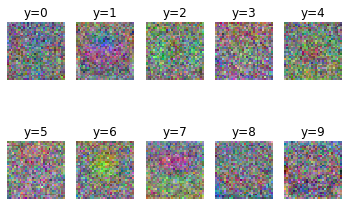

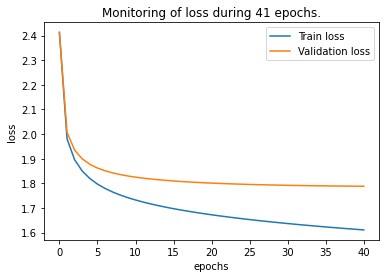

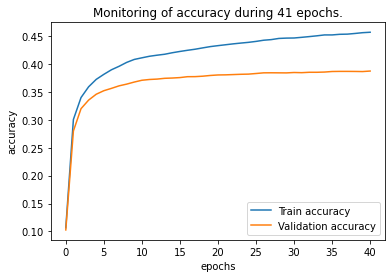

In [20]:
importlib.reload(ut)
ut.montage(W, GDparams)
ut.plot_metric(train_loss, val_loss, GDparams, type="loss")
ut.plot_metric(train_acc, val_acc, GDparams, type="accuracy")

## Experiments

100%|██████████| 40/40 [02:13<00:00,  3.33s/it]


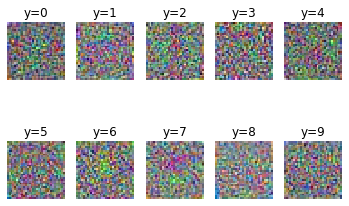

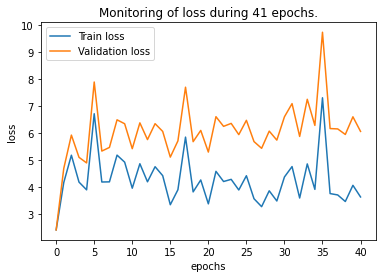

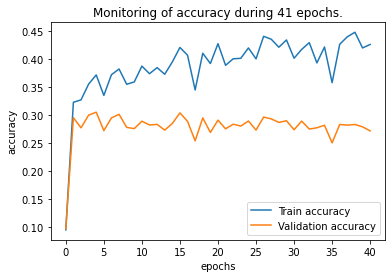

100%|██████████| 40/40 [02:14<00:00,  3.35s/it]


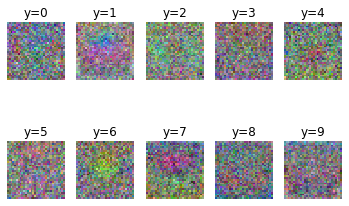

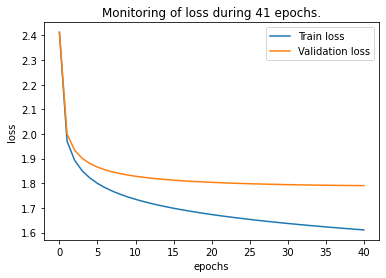

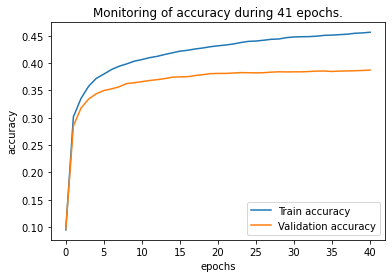

100%|██████████| 40/40 [02:05<00:00,  3.15s/it]


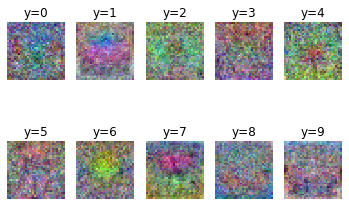

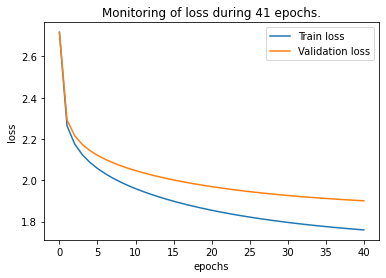

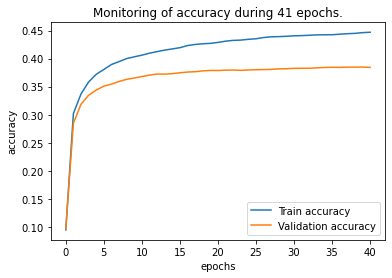

100%|██████████| 40/40 [01:56<00:00,  2.90s/it]


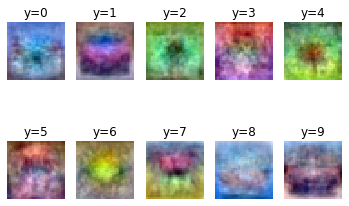

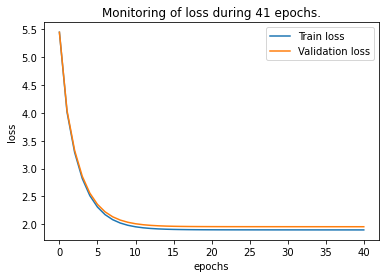

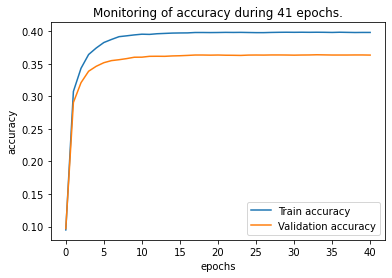

In [10]:
importlib.reload(ut)

GDparams = [{"lambda":0, "n_epochs":40, "n_batch":100, "eta":.1}, {"lambda":0, "n_epochs":40, "n_batch":100, "eta":.001}, 
          {"lambda":.1, "n_epochs":40, "n_batch":100, "eta":.001}, {"lambda":1, "n_epochs":40, "n_batch":100, "eta":.001}]

np.random.seed(42)
seeds = np.random.randint(0, 100, 5)
stats = {i:{"val_loss":[], "train_loss":[], "val_acc":[], "train_acc":[], "test_acc":[]}for i in range(4)}

for i, GDparam in enumerate(GDparams): 
    for seed in seeds:
        np.random.seed(seed)
        W = np.random.normal(mu, sigma, (K,d))
        b = np.random.normal(mu, sigma, (K,1))
        W, b, train_loss, val_loss, train_acc, val_acc = ut.minibatchGD(X_train, Y_train, y_train,  X_val, Y_val, y_val, GDparam, W, b, verbose=False)

        stats[i]["train_loss"].append(train_loss[-1])
        stats[i]["val_loss"].append(val_loss[-1])
        stats[i]["train_acc"].append(train_acc[-1])
        stats[i]["val_acc"].append(val_acc[-1])
        stats[i]["test_acc"].append(ut.ComputeAccuracy(X_test, y_test, W, b))
    
    ut.montage(W, GDparam)
    ut.plot_metric(train_loss, val_loss, GDparam, type="loss", experiment="mandatory")
    ut.plot_metric(train_acc, val_acc, GDparam, type="accuracy", experiment="mandatory")
np.save("History/mandatory_stats.npy", stats)

In [11]:
for i in range(4):
    stats[i]['stats_val_acc'] = [round(np.mean(stats[i]['val_acc']),5), round(np.std(stats[i]['val_acc']),5)]
    stats[i]['stats_train_acc'] = [round(np.mean(stats[i]['train_acc']),5), round(np.std(stats[i]['train_acc']),5)]
    stats[i]['stats_test_acc'] = [round(np.mean(stats[i]['test_acc']),5), round(np.std(stats[i]['test_acc']),5)]
    stats[i]['stats_val_loss'] = [round(np.mean(stats[i]['val_loss']),5), round(np.std(stats[i]['val_loss']),5)]
    stats[i]['stats_train_loss'] = [round(np.mean(stats[i]['train_loss']),5), round(np.std(stats[i]['train_loss']),5)]

    print(f"Conf {i} -> val_acc: {stats[i]['stats_val_acc']} train_acc: {stats[i]['stats_train_acc']} test_acc: {stats[i]['stats_test_acc']}  val_loss: {stats[i]['stats_val_loss']}train_loss: {stats[i]['stats_train_loss']}")

np.save("History/stats.npy", stats)

Conf 0 -> val_acc: [0.28032, 0.00476] train_acc: [0.43448, 0.00891] test_acc: [0.29096, 0.00394]  val_loss: [6.23582, 0.31703]train_loss: [3.73644, 0.28717]
Conf 1 -> val_acc: [0.3848, 0.00132] train_acc: [0.45672, 0.00127] test_acc: [0.39348, 0.00084]  val_loss: [1.79089, 0.00085]train_loss: [1.61084, 0.00144]
Conf 2 -> val_acc: [0.3863, 0.00114] train_acc: [0.44684, 0.00143] test_acc: [0.39634, 0.00147]  val_loss: [1.90145, 0.00089]train_loss: [1.76023, 0.00049]
Conf 3 -> val_acc: [0.36346, 0.00034] train_acc: [0.39894, 0.00058] test_acc: [0.37938, 0.0003]  val_loss: [1.95688, 0.00021]train_loss: [1.89973, 0.00019]


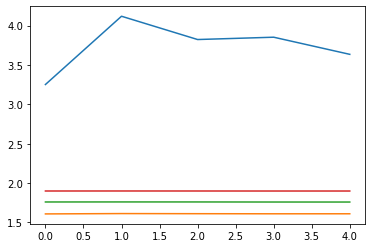

In [14]:
for i in range(4):
    plt.plot(stats[i]['train_loss'])
plt.show()

# Bonus
## Early Stopping 

In [36]:
importlib.reload(ut)
setting = {"lambda":0.1, "n_epochs":200, "n_batch":100, "eta":.001}
np.random.seed(42)
mu, sigma = 0, 0.01
W = np.random.normal(mu, sigma, (K,d))
b = np.random.normal(mu, sigma, (K,1))
W, b, train_loss, val_loss, train_acc, val_acc = ut.minibatchGD(X_train, Y_train, y_train,  X_val, Y_val, y_val, setting, W, b, verbose=True, patience=10, experiment="early_stopping")

8481267899678 | val_loss=1.8694361469498073
100%|██████████| 200/200 [11:26<00:00,  3.43s/it]Epoch 199: train_acc=0.4656 | val_acc=0.3894 | train_loss=1.6897006867459081 | val_loss=1.8609331745882687



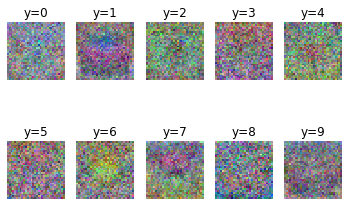

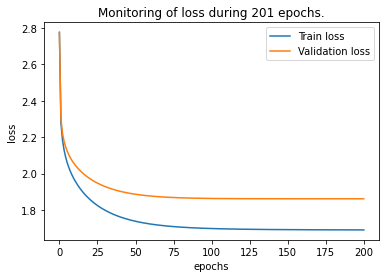

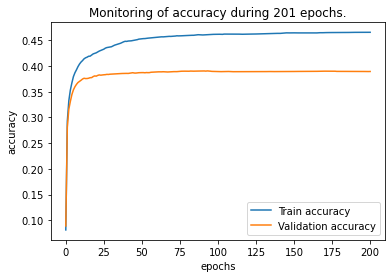

In [39]:
ut.montage(W, setting, experiment="early_stopping")
ut.plot_metric(train_loss, val_loss, setting, type="loss", experiment="early_stopping")
ut.plot_metric(train_acc, val_acc, setting, type="accuracy",experiment="early_stopping")

In [40]:
val_acc[-1]

0.3894

## Bigger dataset

In [29]:
importlib.reload(ut)
X_train_whole, y_train_whole, Y_train_whole = ut.loadData('data_batch_1', clipping=True)
for i in range(2,6):
    X, y, Y = ut.loadData('data_batch_'+str(i), clipping=True)
    X_train_whole = np.concatenate((X, X_train_whole), axis=1)
    y_train_whole = np.concatenate((y, y_train_whole))
    Y_train_whole = np.concatenate((Y, Y_train_whole), axis=1)

X_val_small, y_val_small, Y_val_small = X_train_whole[:,-1000:], y_train_whole[-1000:], Y_train_whole[:,-1000:]
X_train_whole, y_train_whole, Y_train_whole = X_train_whole[:,:-1000], y_train_whole[:-1000], Y_train_whole[:,:-1000]

## normalize with mean and std of train set 
mean = np.mean(X_train_whole, axis=1)
std = np.std(X_train_whole, axis=1)

X_train_whole -= np.outer(mean, np.ones(X_train_whole.shape[1]))
X_train_whole /= np.outer(std, np.ones(X_train_whole.shape[1]))

X_val_small -= np.outer(mean, np.ones(X_val_small.shape[1]))
X_val_small /= np.outer(std, np.ones(X_val_small.shape[1]))

In [31]:
importlib.reload(ut)
np.random.seed(42)
W = np.random.normal(mu, sigma, (K,d))
b = np.random.normal(mu, sigma, (K,1))
GDparams = {"n_batch":100, "n_epochs":40, "eta":0.001, "lambda":0.1}
W, b, train_loss, val_loss, train_acc, val_acc = ut.minibatchGD(X_train_whole, Y_train_whole, y_train_whole, X_val_small, Y_val_small, y_val_small, GDparams, W, b, verbose=True, experiment="whole_data")

100%|██████████| 40/40 [06:45<00:00, 10.14s/it]Epoch 39: train_acc=0.4235510204081633 | val_acc=0.417 | train_loss=1.7617326973755039 | val_loss=1.7824871167056022



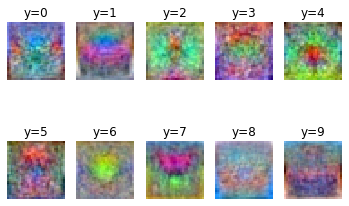

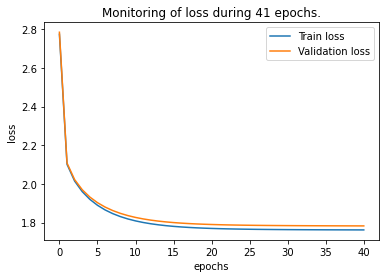

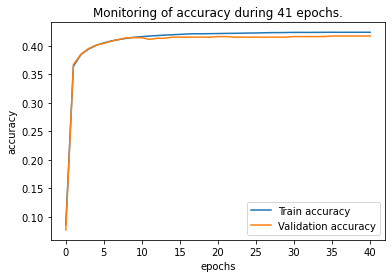

In [33]:
importlib.reload(ut)
ut.montage(W, GDparams, experiment="whole_data")
ut.plot_metric(train_loss, val_loss, GDparams, type="loss", experiment="whole_data")
ut.plot_metric(train_acc, val_acc, GDparams, type="accuracy", experiment="whole_data")

## Xavier Initialization

In [54]:
importlib.reload(ut)
setting = {"lambda":.1, "n_epochs":40, "n_batch":100, "eta":.001}

np.random.seed(42)
seeds = np.random.randint(0, 100, 5)
stats_xavier = {"val_loss":[], "train_loss":[], "val_acc":[], "train_acc":[], "test_acc":[]}

for seed in seeds:
    np.random.seed(seed)
    mu, sigma = 0, 1/np.sqrt(d)
    W = np.random.normal(mu, sigma, (K,d))
    b = np.random.normal(mu, sigma, (K,1))
    W, b, train_loss, val_loss, train_acc, val_acc = ut.minibatchGD(X_train, Y_train, y_train,  X_val, Y_val, y_val, setting, W, b, verbose=False)

    stats_xavier["train_loss"].append(train_loss[-1])
    stats_xavier["val_loss"].append(val_loss[-1])
    stats_xavier["train_acc"].append(train_acc[-1])
    stats_xavier["val_acc"].append(val_acc[-1])


stats_xavier['stats_val_acc'] = [round(np.mean(stats_xavier['val_acc']),5), round(np.std(stats_xavier['val_acc']),5)]
stats_xavier['stats_train_acc'] = [round(np.mean(stats_xavier['train_acc']),5), round(np.std(stats_xavier['train_acc']),5)]
stats_xavier['stats_val_loss'] = [round(np.mean(stats_xavier['val_loss']),5), round(np.std(stats_xavier['val_loss']),5)]
stats_xavier['stats_train_loss'] = [round(np.mean(stats_xavier['train_loss']),5), round(np.std(stats_xavier['train_loss']),5)]

100%|██████████| 40/40 [02:03<00:00,  3.08s/it]


In [25]:
print(f"Xavier -> val_acc: {stats_xavier['stats_val_acc']} train_acc: {stats_xavier['stats_train_acc']} val_loss: {stats_xavier['stats_val_loss']}train_loss: {stats_xavier['stats_train_loss']}")

np.save('History/stats_xavier.npy', stats_xavier)

Xavier -> val_acc: [0.38502, 0.00094] train_acc: [0.45652, 0.00069] val_loss: [1.89478, 0.0007]train_loss: [1.734, 0.0004]


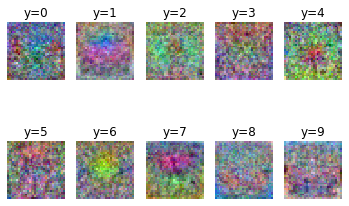

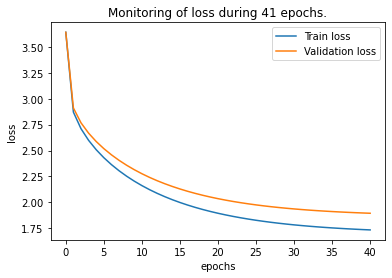

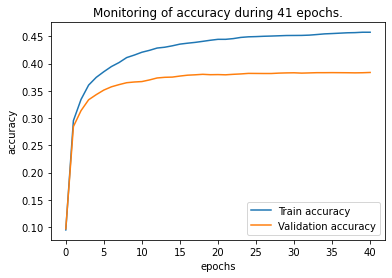

In [26]:
ut.montage(W, setting)
ut.plot_metric(train_loss, val_loss, setting, type="loss")
ut.plot_metric(train_acc, val_acc, setting, type="accuracy")

## Learning rate Annealing 

In [68]:
importlib.reload(ut)
setting = {"lambda":.1, "n_epochs":40, "n_batch":100, "eta":.01, "eta_decay":0.1 , 'eta_decay_freq':10}

np.random.seed(42)
seeds = np.random.randint(0, 100, 5)
stats_decay = {"val_loss":[], "train_loss":[], "val_acc":[], "train_acc":[], "test_acc": []}

for seed in seeds:
    np.random.seed(seed)
    mu, sigma = 0, 0.01 
    W = np.random.normal(mu, sigma, (K,d))
    b = np.random.normal(mu, sigma, (K,1))
    W, b, train_loss, val_loss, train_acc, val_acc = ut.minibatchGD(X_train, Y_train, y_train,  X_val, Y_val, y_val, setting, W, b, verbose=False, annealing=True, experiment="decay")

    stats_decay["train_loss"].append(train_loss[-1])
    stats_decay["val_loss"].append(val_loss[-1])
    stats_decay["train_acc"].append(train_acc[-1])
    stats_decay["val_acc"].append(val_acc[-1])
    stats_decay["test_acc"].append(ut.ComputeAccuracy(X_test, y_test, W, b))

100%|██████████| 40/40 [02:26<00:00,  3.65s/it]


In [69]:
stats_decay['stats_val_acc'] = [round(np.mean(stats_decay['val_acc']),5), round(np.std(stats_decay['val_acc']),6)]
stats_decay['stats_train_acc'] = [round(np.mean(stats_decay['train_acc']),5), round(np.std(stats_decay['train_acc']),6)]
stats_decay['stats_test_acc'] = [round(np.mean(stats_decay['test_acc']),5), round(np.std(stats_decay['test_acc']),6)]
stats_decay['stats_val_loss'] = [round(np.mean(stats_decay['val_loss']),5), round(np.std(stats_decay['val_loss']),6)]
stats_decay['stats_train_loss'] = [round(np.mean(stats_decay['train_loss']),5), round(np.std(stats_decay['train_loss']),6)]


print(f"Conf -> val_acc: {stats_decay['stats_val_acc']} train_acc: {stats_decay['stats_train_acc']} test_acc: {stats_decay['stats_test_acc']} val_loss: {stats_decay['stats_val_loss']}train_loss: {stats_decay['stats_train_loss']}")

Conf -> val_acc: [0.38346, 0.001616] train_acc: [0.43238, 0.001622] test_acc: [0.39596, 0.000496] val_loss: [1.96352, 0.001245]train_loss: [1.84522, 0.000964]


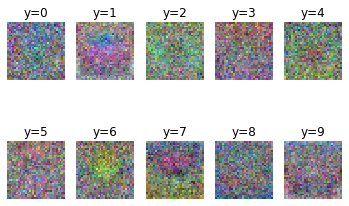

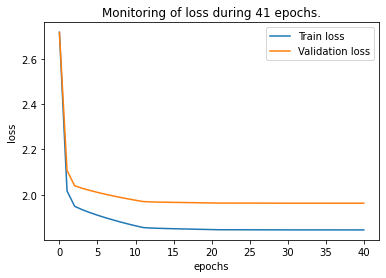

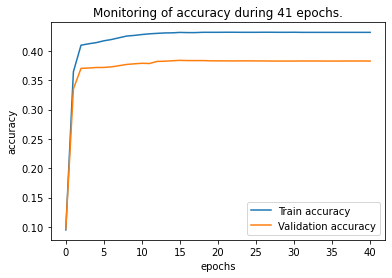

In [70]:
ut.montage(W, setting, experiment="decay")
ut.plot_metric(train_loss, val_loss, setting, type="loss", experiment="decay" )
ut.plot_metric(train_acc, val_acc, setting, type="accuracy", experiment="decay")

In [76]:
print(f"Conf {i} -> {stats_decay['stats_val_acc'][0]} $\pm$ {stats_decay['stats_val_acc'][1]} & {stats_decay['stats_train_acc'][0]} $\pm$ {stats_decay['stats_train_acc'][1]} & {stats_decay['stats_val_loss'][0]} $\pm$ {stats_decay['stats_val_loss'][1]} & {stats_decay['stats_train_loss'][0]} $\pm$ {stats_decay['stats_train_loss'][1]} ")

Conf 3 -> 0.38346 $\pm$ 0.001616 & 0.43238 $\pm$ 0.001622 & 1.96352 $\pm$ 0.001245 & 1.84522 $\pm$ 0.000964 


## Shuffle the order 

In [31]:
importlib.reload(ut)
setting = {"lambda":.1, "n_epochs":40, "n_batch":50, "eta":.001}

np.random.seed(42)
seeds = np.random.randint(0, 100, 5)
stats_shuffle = {"val_loss":[], "train_loss":[], "val_acc":[], "train_acc":[]}

for seed in seeds:
    np.random.seed(seed)
    mu, sigma = 0, 0.01 
    W = np.random.normal(mu, sigma, (K,d))
    b = np.random.normal(mu, sigma, (K,1))
    W, b, train_loss, val_loss, train_acc, val_acc = ut.minibatchGD(X_train, Y_train, y_train,  X_val, Y_val, y_val, setting, W, b, verbose=True, patience=2, reorder=True)

    stats_shuffle["train_loss"].append(train_loss[-1])
    stats_shuffle["val_loss"].append(val_loss[-1])
    stats_shuffle["train_acc"].append(train_acc[-1])
    stats_shuffle["val_acc"].append(val_acc[-1])


stats_shuffle['stats_val_acc'] = [round(np.mean(stats_shuffle['val_acc']),5), round(np.std(stats_shuffle['val_acc']),5)]
stats_shuffle['stats_train_acc'] = [round(np.mean(stats_shuffle['train_acc']),5), round(np.std(stats_shuffle['train_acc']),5)]
stats_shuffle['stats_val_loss'] = [round(np.mean(stats_shuffle['val_loss']),5), round(np.std(stats_shuffle['val_loss']),5)]
stats_shuffle['stats_train_loss'] = [round(np.mean(stats_shuffle['train_loss']),5), round(np.std(stats_shuffle['train_loss']),5)]

print(f"Conf -> val_acc: {stats_shuffle['stats_val_acc']} train_acc: {stats_shuffle['stats_train_acc']} val_loss: {stats_shuffle['stats_val_loss']}train_loss: {stats_shuffle['stats_train_loss']}")


 52%|█████▎    | 21/40 [01:17<01:10,  3.70s/it]Epoch 21: train_acc=0.451 | val_acc=0.383 | train_loss=1.7524293107614046 | val_loss=1.901846077496201
Early Stopping @ Epoch: 21

 52%|█████▎    | 21/40 [01:16<01:09,  3.65s/it]Epoch 21: train_acc=0.4476 | val_acc=0.3829 | train_loss=1.7528530254071717 | val_loss=1.8999833471692822
Early Stopping @ Epoch: 21

 52%|█████▎    | 21/40 [01:15<01:08,  3.60s/it]Epoch 21: train_acc=0.4491 | val_acc=0.3824 | train_loss=1.7526581890103992 | val_loss=1.900049583025342
Early Stopping @ Epoch: 21

 52%|█████▎    | 21/40 [01:15<01:08,  3.60s/it]Epoch 21: train_acc=0.4488 | val_acc=0.3825 | train_loss=1.75203571342075 | val_loss=1.9000593123991512
Early Stopping @ Epoch: 21

 52%|█████▎    | 21/40 [01:10<01:04,  3.37s/it]Epoch 21: train_acc=0.4475 | val_acc=0.3814 | train_loss=1.7517650210261029 | val_loss=1.8996591239022849
Early Stopping @ Epoch: 21
Conf -> val_acc: [0.38244, 0.00057] train_acc: [0.4488, 0.00127] val_loss: [1.90032, 0.00078]train_los

TypeError: _save_dispatcher() missing 1 required positional argument: 'arr'

In [35]:
np.save('History/shuffle_stats.npy', stats_shuffle)

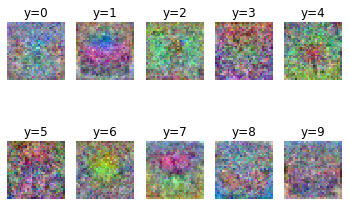

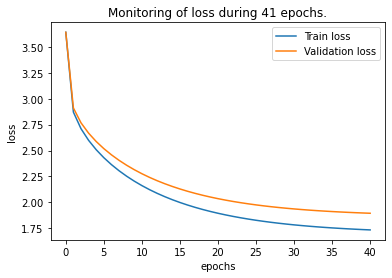

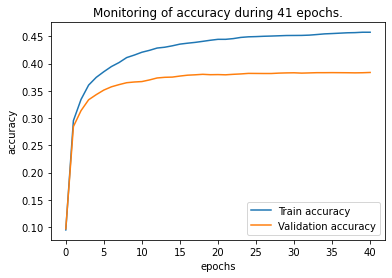

In [30]:
ut.montage(W, setting)
ut.plot_metric(train_loss, val_loss, setting, type="loss")
ut.plot_metric(train_acc, val_acc, setting, type="accuracy")

0.3972

## TODOs

* Use all the available training data for training (all five batches minus a small
subset of the training images for a validation set). Decrease the size of the
validation set down to around 1000.
* Train for a longer time and use your validation set to make sure you don't
overfit or to keep a record of the best model before you begin to overfit.
* Play around with decaying the learning rate by a factor around :9 after each epoch.
Or you can decay the learning rate by a factor of 10 after every nth epoch.
* Shuffle the order of your training examples at the beginning of every epoch.

## Bonus SVM

In [9]:
importlib.reload(ut)

W = np.random.normal(mu, sigma, (K,d))
b = np.random.normal(mu, sigma, (K,1))
GDparams = {"n_batch":100, "n_epochs":40, "eta":1e-3, "lambda":0}
W, b, train_loss, val_loss, train_acc, val_acc = ut.minibatchGD(X_train, Y_train, y_train,  X_val, Y_val, y_val, GDparams, W, b, verbose=True, loss="svm")

100%|██████████| 40/40 [02:42<00:00,  4.05s/it]Epoch 39: train_acc=0.4834 | val_acc=0.3478 | train_loss=1.5330932677958973 | val_loss=1.8443753629203603



100%|██████████| 40/40 [02:15<00:00,  3.38s/it]


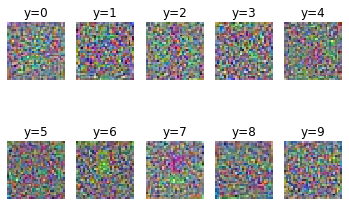

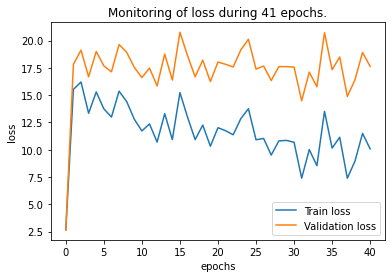

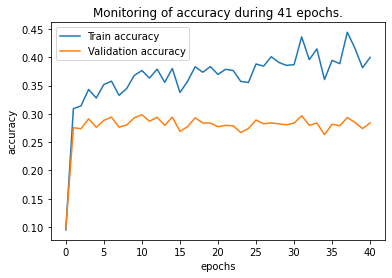

100%|██████████| 40/40 [02:11<00:00,  3.29s/it]


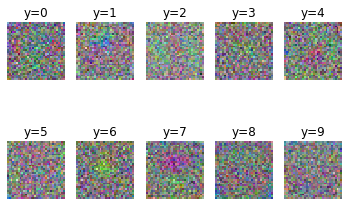

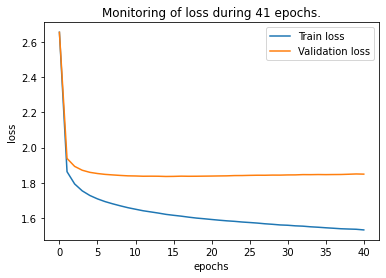

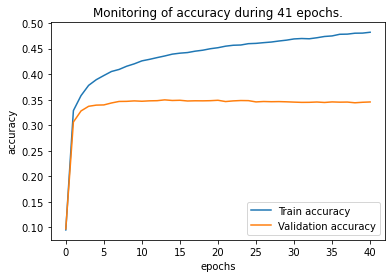

100%|██████████| 40/40 [02:07<00:00,  3.20s/it]


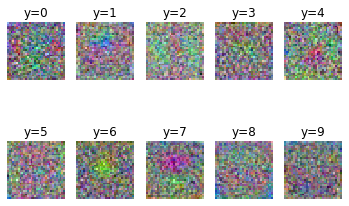

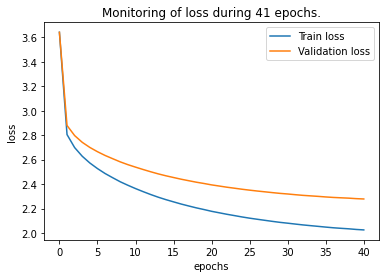

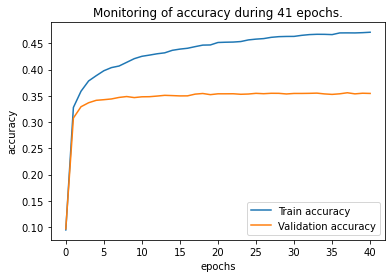

100%|██████████| 40/40 [02:19<00:00,  3.50s/it]


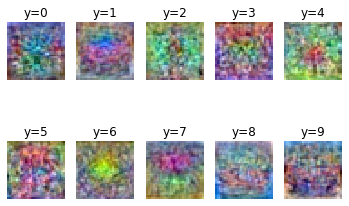

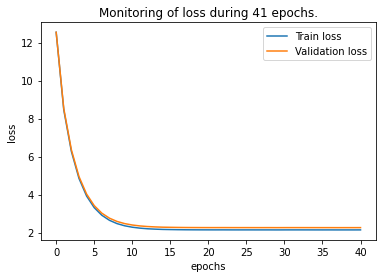

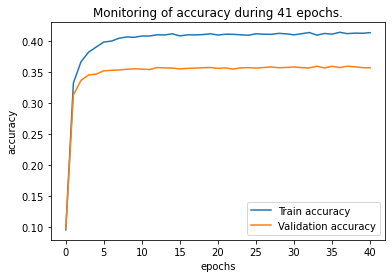

In [56]:
importlib.reload(ut)

GDparams = [{"lambda":0, "n_epochs":40, "n_batch":100, "eta":.1}, {"lambda":0, "n_epochs":40, "n_batch":100, "eta":.001}, 
          {"lambda":.1, "n_epochs":40, "n_batch":100, "eta":.001}, {"lambda":1, "n_epochs":40, "n_batch":100, "eta":.001}]

np.random.seed(42)
seeds = np.random.randint(0, 100, 5)
stats_svm = {i:{"val_loss":[], "train_loss":[], "val_acc":[], "train_acc":[], "test_acc":[]}for i in range(4)}

for i, GDparam in enumerate(GDparams): 
    for seed in seeds:
        np.random.seed(seed)
        W = np.random.normal(mu, sigma, (K,d))
        b = np.random.normal(mu, sigma, (K,1))
        W, b, train_loss, val_loss, train_acc, val_acc = ut.minibatchGD(X_train, Y_train, y_train,  X_val, Y_val, y_val, GDparam, W, b, verbose=False, loss="svm", experiment="svm")

        stats_svm[i]["train_loss"].append(train_loss[-1])
        stats_svm[i]["val_loss"].append(val_loss[-1])
        stats_svm[i]["train_acc"].append(train_acc[-1])
        stats_svm[i]["val_acc"].append(val_acc[-1])
        stats_svm[i]["test_acc"].append(ut.ComputeAccuracy(X_test, y_test, W, b))
    
    ut.montage(W, GDparam, experiment="svm")
    ut.plot_metric(train_loss, val_loss, GDparam, type="loss", experiment="svm")
    ut.plot_metric(train_acc, val_acc, GDparam, type="accuracy", experiment="svm")
np.save("History/stats_svm.npy", stats_svm)

In [57]:
for i in range(4):
    stats_svm[i]['stats_val_acc'] = [round(np.mean(stats_svm[i]['val_acc']),5), round(np.std(stats_svm[i]['val_acc']),5)]
    stats_svm[i]['stats_train_acc'] = [round(np.mean(stats_svm[i]['train_acc']),5), round(np.std(stats_svm[i]['train_acc']),5)]
    stats_svm[i]['stats_test_acc'] = [round(np.mean(stats_svm[i]['test_acc']),5), round(np.std(stats_svm[i]['test_acc']),5)]
    stats_svm[i]['stats_val_loss'] = [round(np.mean(stats_svm[i]['val_loss']),5), round(np.std(stats_svm[i]['val_loss']),5)]
    stats_svm[i]['stats_train_loss'] = [round(np.mean(stats_svm[i]['train_loss']),5), round(np.std(stats_svm[i]['train_loss']),5)]

    print(f"Conf {i} -> val_acc: {stats_svm[i]['stats_val_acc']} train_acc: {stats_svm[i]['stats_train_acc']} test_acc: {stats_svm[i]['stats_test_acc']}  val_loss: {stats_svm[i]['stats_val_loss']}train_loss: {stats_svm[i]['stats_train_loss']}")

np.save("History/stats_svm.npy", stats_svm)

Conf 0 -> val_acc: [0.28516, 0.00484] train_acc: [0.40906, 0.01643] test_acc: [0.28806, 0.00599]  val_loss: [17.14759, 1.24248]train_loss: [9.55676, 1.28218]
Conf 1 -> val_acc: [0.34528, 0.00156] train_acc: [0.4798, 0.00205] test_acc: [0.35396, 0.00126]  val_loss: [1.85071, 0.0022]train_loss: [1.53574, 0.00101]
Conf 2 -> val_acc: [0.35428, 0.00101] train_acc: [0.46964, 0.00179] test_acc: [0.36388, 0.00097]  val_loss: [2.27662, 0.00197]train_loss: [2.0239, 0.00107]
Conf 3 -> val_acc: [0.35776, 0.00085] train_acc: [0.41314, 0.00079] test_acc: [0.36144, 0.00063]  val_loss: [2.26465, 0.0005]train_loss: [2.14518, 0.00047]


In [61]:
for i in range(4):
    print(f"Conf {i} -> {stats_svm[i]['stats_train_acc'][0]} $\pm$ {stats_svm[i]['stats_train_acc'][1]} & {stats_svm[i]['stats_val_acc'][0]} $\pm$ {stats_svm[i]['stats_val_acc'][1]} & {stats_svm[i]['stats_test_acc'][0]} $\pm$ {stats_svm[i]['stats_test_acc'][1]} ")

Conf 0 -> 0.40906 $\pm$ 0.01643 & 0.28516 $\pm$ 0.00484 & 0.28806 $\pm$ 0.00599 
Conf 1 -> 0.4798 $\pm$ 0.00205 & 0.34528 $\pm$ 0.00156 & 0.35396 $\pm$ 0.00126 
Conf 2 -> 0.46964 $\pm$ 0.00179 & 0.35428 $\pm$ 0.00101 & 0.36388 $\pm$ 0.00097 
Conf 3 -> 0.41314 $\pm$ 0.00079 & 0.35776 $\pm$ 0.00085 & 0.36144 $\pm$ 0.00063 
